# Contour plots of tracer concentration on shelf bottom, not counting the canyon lid



Map hcw on shelf by looking at bottom cells and multiplying their concentration by their area.

The canyon lid is not, strictly speaking, part of the shelf bottom, so I will leave it out of the average.

In [1]:
#KRM

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

import matplotlib.cm as cm

import matplotlib as mpl

from math import *

from mpl_toolkits.mplot3d.axes3d import Axes3D

import scipy.io

import scipy as spy

%matplotlib inline

from netCDF4 import Dataset

import pylab as pl

import os 

import sys

import seaborn as sns


In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 


In [3]:
sns.set()
sns.set_style('white')
sns.set_context('talk')

In [13]:
#Base case, iso =1 , No 3d diff.
#CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

NoCCanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc'
NoCCanyonGridOut = Dataset(NoCCanyonGrid)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

Ptracer='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/ptracersGlob.nc'
PtracerOut = Dataset(Ptracer)

Ptracer12='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run12/ptracersGlob.nc'
PtracerOut12 = Dataset(Ptracer12)

Ptracer11='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run11/ptracersGlob.nc'
PtracerOut11 = Dataset(Ptracer11)

Ptracer30='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run30/ptracersGlob.nc'
PtracerOut30 = Dataset(Ptracer30)

Ptracer07='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/ptracersGlob.nc'
PtracerOut07 = Dataset(Ptracer07)

Ptracer25='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run25/ptracersGlob.nc'
PtracerOut25 = Dataset(Ptracer25)

Ptracer24='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run24/ptracersGlob.nc'
PtracerOut24 = Dataset(Ptracer24)

Ptracer3D04='/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run04/ptracersGlob.nc'
PtracerOut3D04 = Dataset(Ptracer3D04)

Ptracer3D05='/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run05/ptracersGlob.nc'
PtracerOut3D05 = Dataset(Ptracer3D05)

Ptracer3D06='/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run06/ptracersGlob.nc'
PtracerOut3D06 = Dataset(Ptracer3D06)



In [14]:
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
bathy = rout.getField(CanyonGrid, 'Depth')
bathyNoC = rout.getField(NoCCanyonGrid, 'Depth')

hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

hFacCNoC = rout.getField(NoCCanyonGrid, 'HFacC')
MaskCNoC = rout.getMask(NoCCanyonGrid, 'HFacC')
rANoC = rout.getField(NoCCanyonGrid, 'rA')
rA = rout.getField(CanyonGrid, 'rA')

z = CanyonStateOut.variables['Z']

time = CanyonStateOut.variables['T']

In [15]:
Tr03 = rout.getField(Ptracer,'Tr1') # 


In [16]:
Tr12 = rout.getField(Ptracer12,'Tr3') # 


In [17]:
Tr07 = rout.getField(Ptracer07,'Tr1') # 

In [18]:
Tr25 = rout.getField(Ptracer25,'Tr1') # 

In [19]:
Tr3D04 = rout.getField(Ptracer3D04,'Tr1') # 

In [20]:
Tr3D05 = rout.getField(Ptracer3D05,'Tr1') # 
Tr3D06 = rout.getField(Ptracer3D06,'Tr1') # 

In [21]:
Tr11 = rout.getField(Ptracer11,'Tr2') # 
Tr24 = rout.getField(Ptracer24,'Tr1') # 

In [22]:
Tr30 = rout.getField(Ptracer30,'Tr1')

In [23]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcArea(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((19,360,360))
    Conc = np.empty((19,360,360))
    Area = np.empty((360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis

    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for i in range(360):
            for j in range(360):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                ConcArea[tt,i,j] = TrBottom*ra[i,j]
                Conc[tt,i,j] = TrBottom
                Area[i,j] = ra[i,j]
    
    print(np.shape(ConcArea))
    
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    

    #ConcAreaMasked = np.ma.masked_values(ConcDepths,-2.5)
    #ConcDepths[np.where(np.ma.getmask(ConcDepthsMasked)==True)] = np.nan

    return (ConcArea,np.ma.masked_array(Conc, mask=maskShelf), Area)

In [24]:
ConcArea1,Conc1,Area1=ConcArea(Tr03, hFacC, rA, bathy)


(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


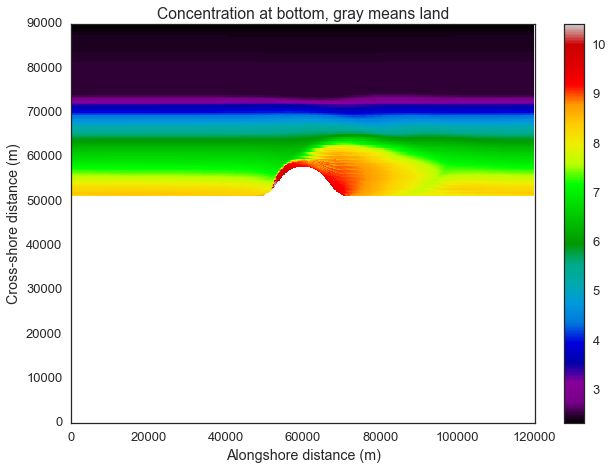

In [25]:
sns.set_context('talk',font_scale=1.0)
plt.pcolor(xc[1,:],yc[:,1],Conc1[10,:,:],cmap='spectral')
cbar = plt.colorbar()
plt.title('Concentration at bottom, gray means land')
plt.ylabel('Cross-shore distance (m)')
plt.xlabel('Alongshore distance (m)')

In [26]:
ConcArea3,Conc3,Area3=ConcArea(Tr12, hFacC, rA, bathy)


(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


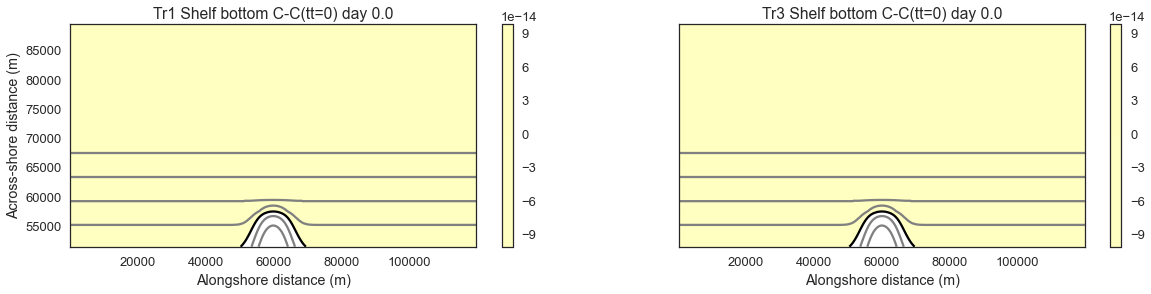

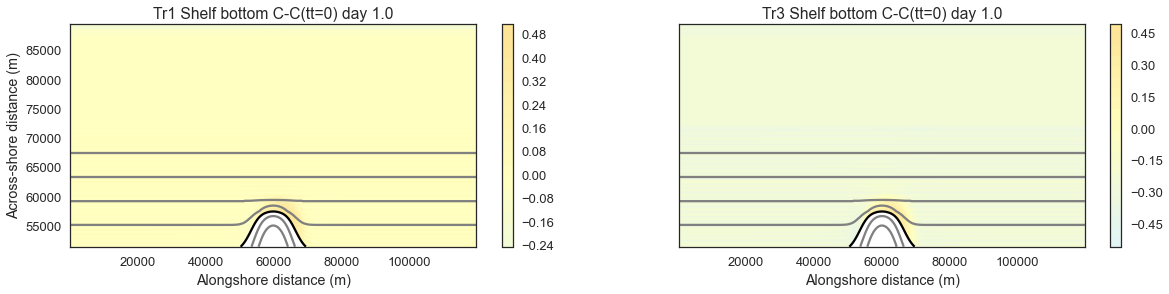

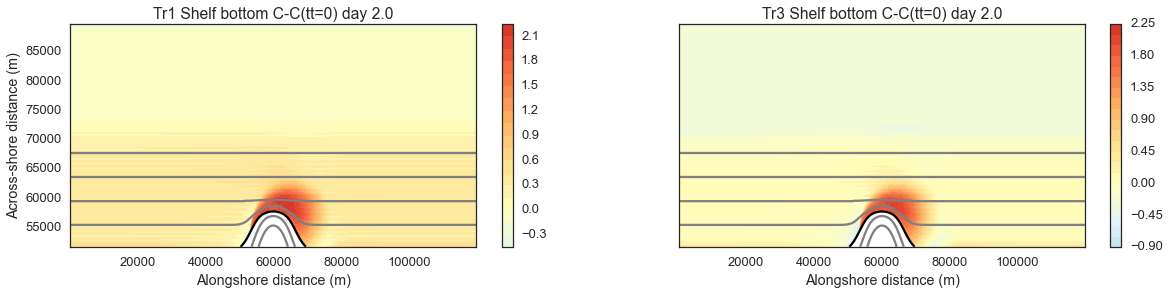

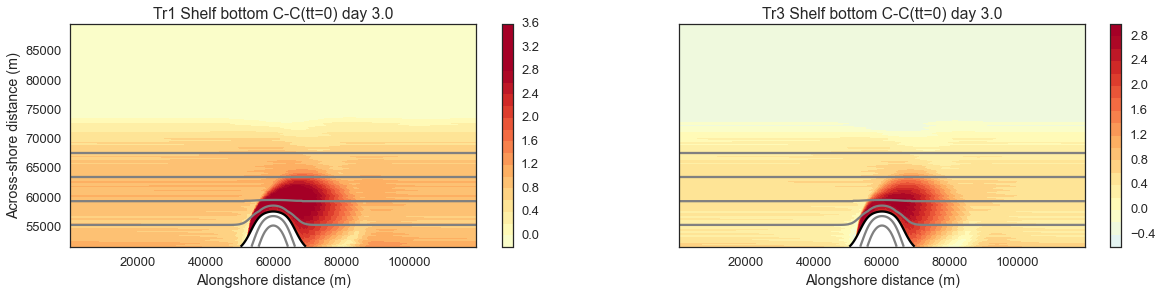

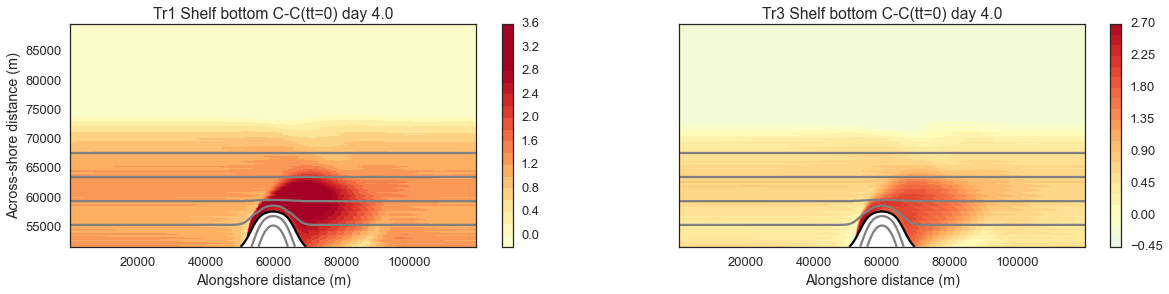

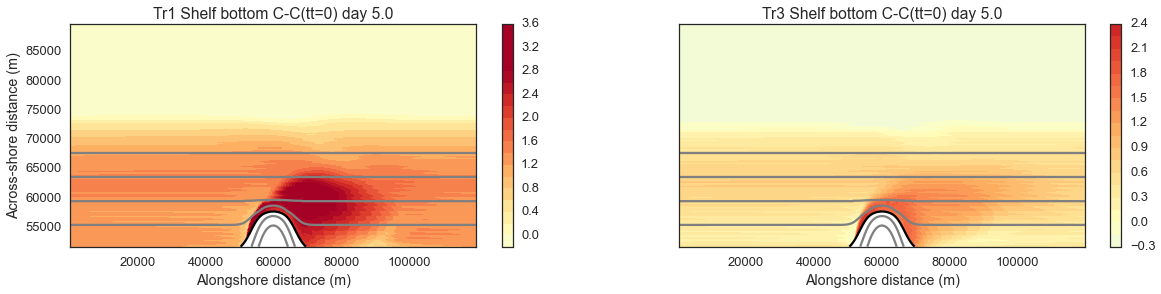

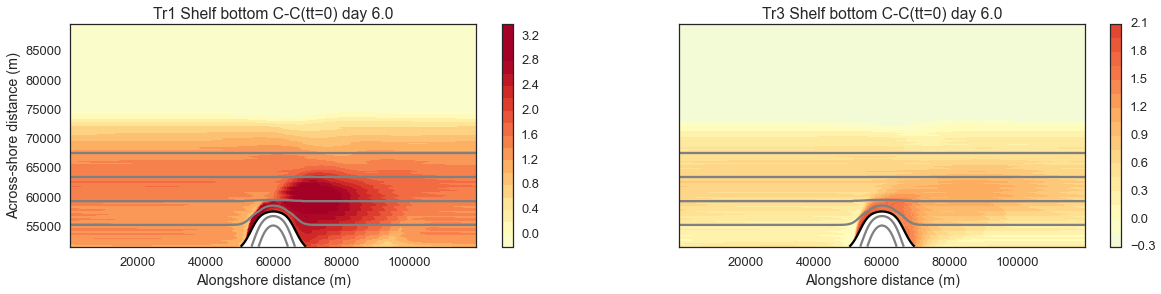

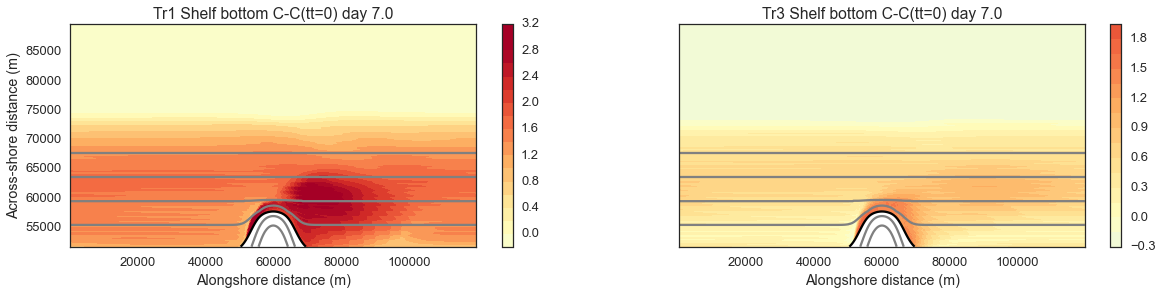

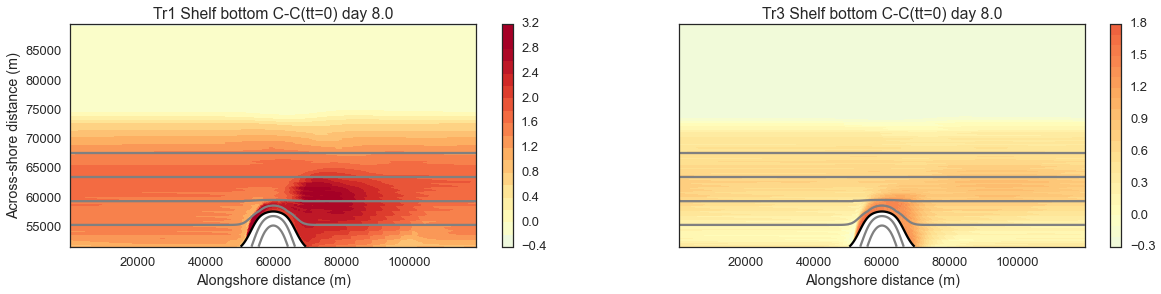

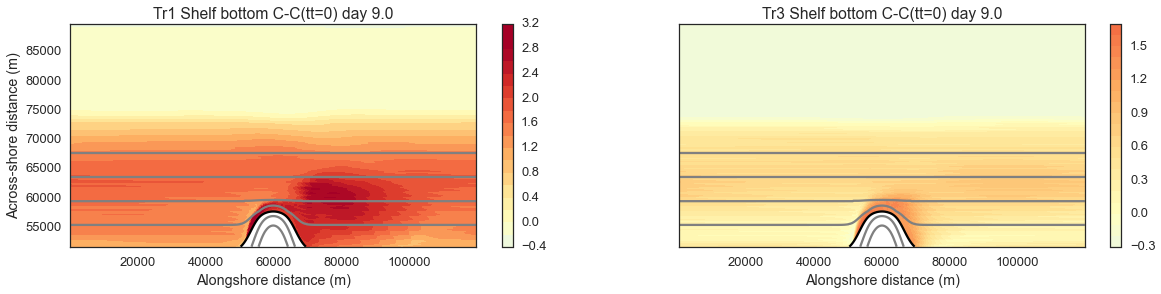

In [27]:
sns.set_context('talk', font_scale=1.0)

for tt in np.arange(0,19,2):
    
    fig,((ax1),(ax2)) = plt.subplots(1, 2, figsize=(20, 4),  sharey=True, sharex=True)
    
    iso = ax1.contourf(xc[227:,:],yc[227:,:],Conc1[tt,227:,:]-Conc1[0,227:,:],20,
                       vmin=-2.8,vmax=2.8,cmap='RdYlBu_r')
    cb = plt.colorbar(iso, shrink=1,ax=ax1)
    #cb.set_label('')
    cset = ax1.contour(xc[227:,:],yc[227:,:],-bathy[227:,:],[-300,-200, rc[30],-125,-100,-75,-50],
                       colors=['0.50','0.50','k','0.50','0.50','0.50','0.50'],linewidth=1, rstride=2, cstride=2,zdir='z')

    ax1.set_aspect('auto')
    ax1.set_title('Tr1 Shelf bottom C-C(tt=0) day %0.1f ' %(tt/2.0))
    ax1.set_ylabel('Across-shore distance (m)')
    ax1.set_xlabel('Alongshore distance (m)')
    
    iso2 = ax2.contourf(xc[227:,:],yc[227:,:],Conc3[tt,227:,:]-Conc3[0,227:,:],20,
                        vmin=-2.8,vmax=2.8,cmap='RdYlBu_r')
    cb2 = plt.colorbar(iso2, shrink=1,ax=ax2)
    #cb2.set_label('m')
    cset = ax2.contour(xc[227:,:],yc[227:,:],-bathy[227:,:],[-300,-200, rc[30],-125,-100,-75,-50],
                       colors=['0.50','0.50','k','0.50','0.50','0.50','0.50'],linewidth=1, rstride=2, cstride=2,zdir='z')

    ax2.set_aspect('auto')
    ax2.set_title('Tr3 Shelf bottom C-C(tt=0) day %0.1f ' %(tt/2.0))
    #ax2.set_ylabel('Across-shore distance (m)')
    ax2.set_xlabel('Alongshore distance (m)')
    
    plt.tight_layout
    plt.show

#fig.savefig('/ocean/kramosmu/Figures/BathyShelfBoxComplete.eps', format='eps', dpi=1000, bbox_inches='tight')

Note that I used the flat shelf mask to find the "shelf bottom". This means that the region over the canyon is the concentration*area over the lid of the canyon.

In [28]:
ConcArea1noc,Conc1noc,Area1noc=ConcArea(Tr07, hFacCNoC, rANoC, bathyNoC)

(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [29]:
ConcArea3noc,Conc3noc,Area3noc=ConcArea(Tr25, hFacCNoC, rANoC, bathyNoC)

(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [30]:
ConcArea3D04,Conc3D04,Area3D04=ConcArea(Tr3D04, hFacC, rA, bathy)

(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [31]:
ConcArea3D05,Conc3D05,Area3D05=ConcArea(Tr3D05, hFacC, rA, bathy)
ConcArea3D06,Conc3D06,Area3D06=ConcArea(Tr3D06, hFacC, rA, bathy)
ConcArea11,Conc11,Area11=ConcArea(Tr11, hFacC, rA, bathy)
ConcArea24,Conc24,Area24=ConcArea(Tr24, hFacCNoC, rANoC, bathyNoC)

(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [32]:
ConcArea30,Conc30,Area30=ConcArea(Tr30, hFacCNoC, rANoC, bathyNoC)

(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/home/kramosmu/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/kramosmu/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/kramosmu/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


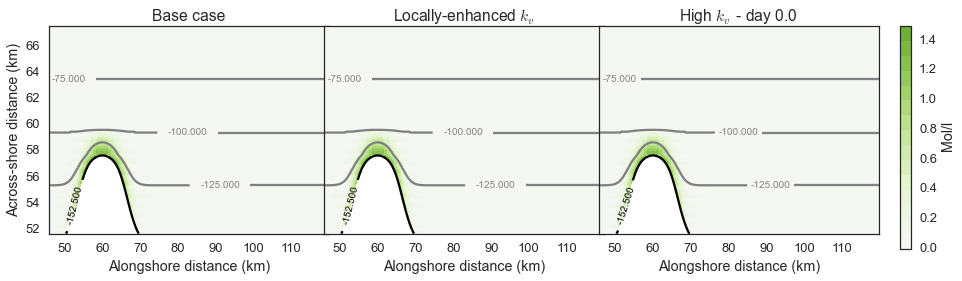

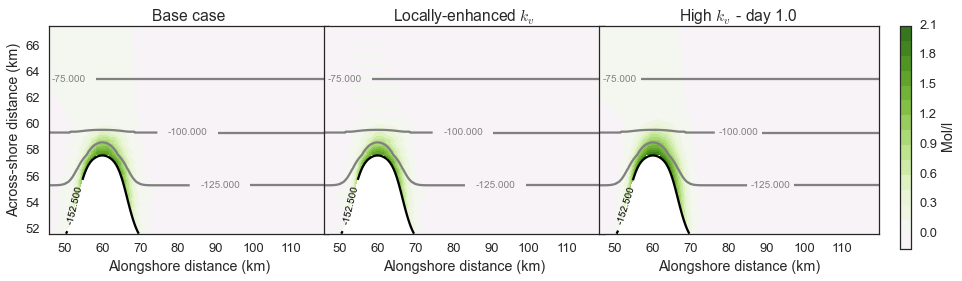

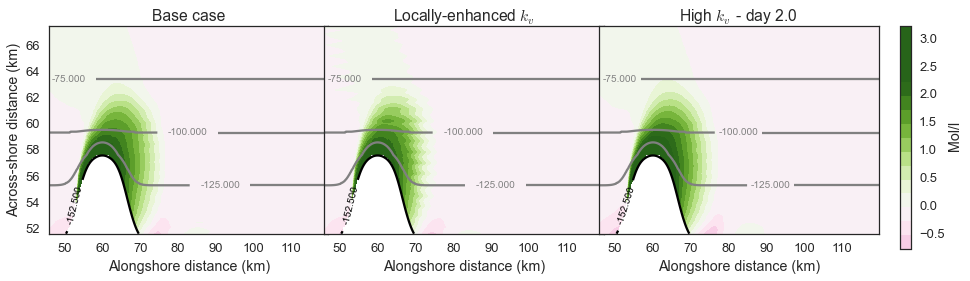

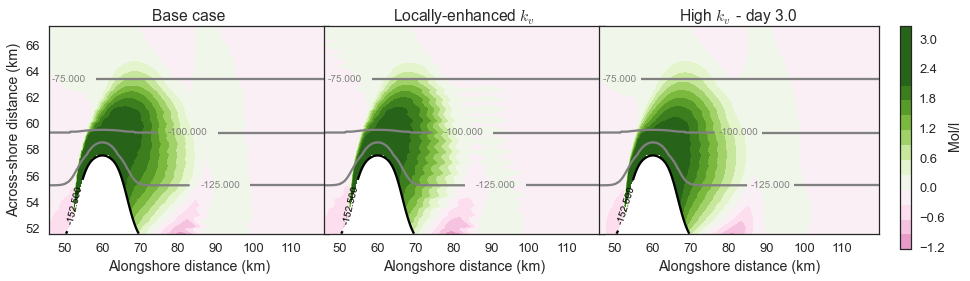

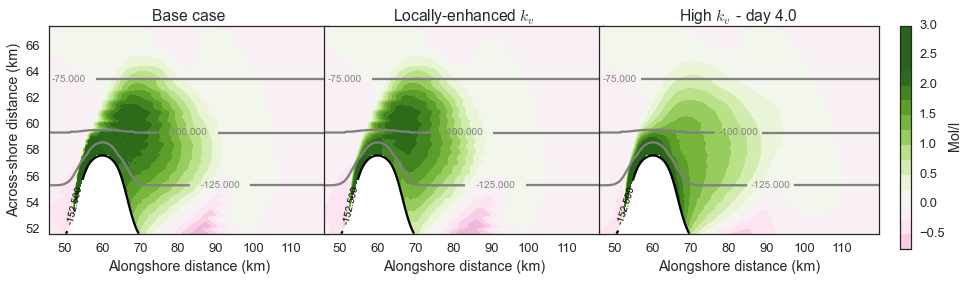

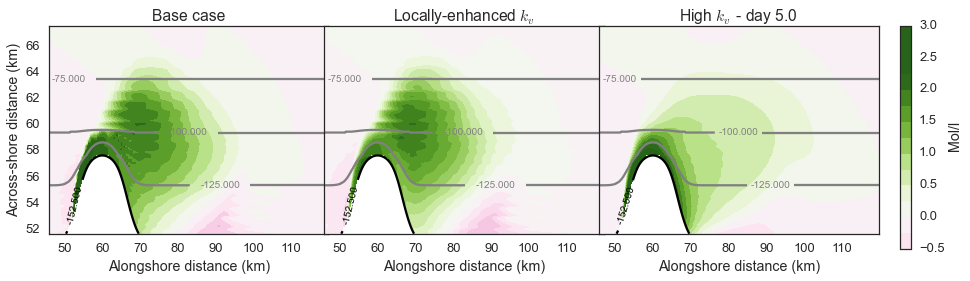

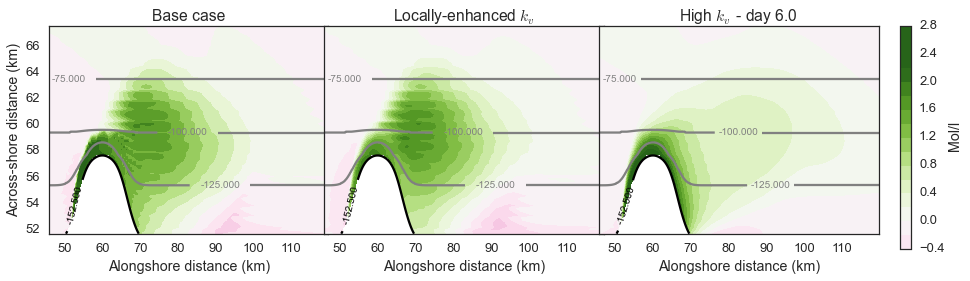

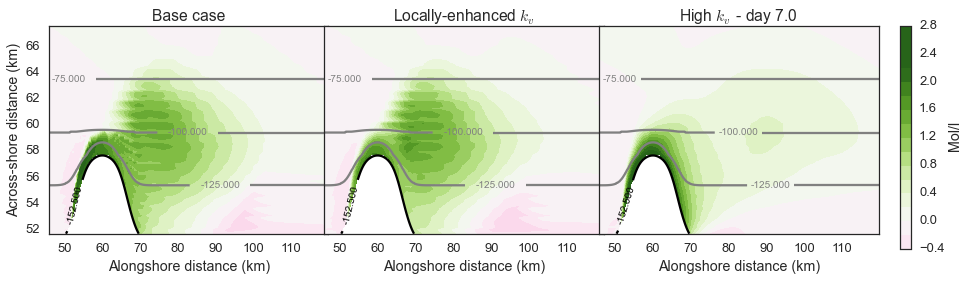

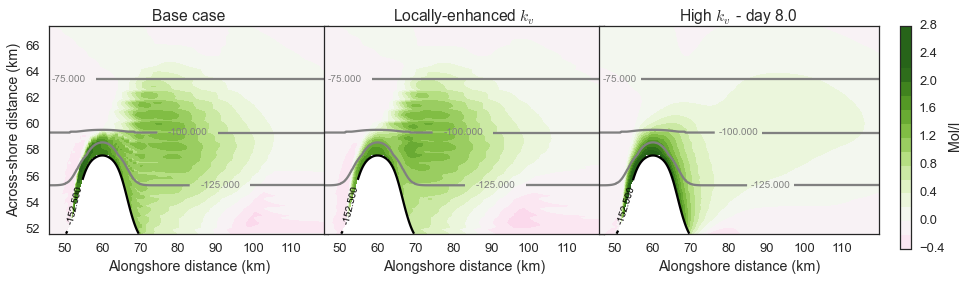

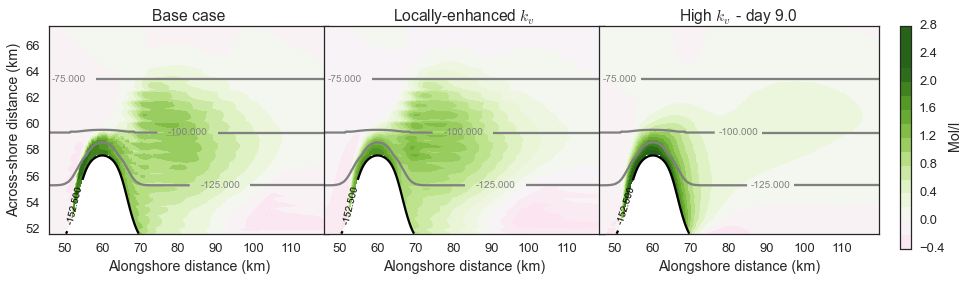

In [33]:
sns.set_context('talk', font_scale=1.0)

for tt in np.arange(0,19,2):
    
    fig,((ax1),(ax2),(ax3)) = plt.subplots(1, 3, figsize=(16, 4),  sharey=True, sharex=True)
    
    iso = ax1.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,Conc1[tt,227:300,100:]-Conc1noc[tt,227:300,100:],
                       15, vmax=2.2, vmin=-2.2,cmap='PiYG')
    cset = ax1.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,-bathy[227:300,100:],[rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],linewidth=1, rstride=2, cstride=2,zdir='z')
    ax1.clabel(cset, inline=1, fontsize=10)
    
    ax1.set_aspect('auto')
    ax1.set_title('Base case')
    ax1.set_ylabel('Across-shore distance (km)')
    ax1.set_xlabel('Alongshore distance (km)')
    
    #-------------------------------------------------------------------------------------------------------------------
    iso2 = ax2.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        Conc3D06[tt,227:300,100:]-Conc30[tt,227:300,100:],15,vmax=2.2, vmin=-2.2,cmap='PiYG')
    
    cset = ax2.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,-bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50], colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z')
    ax2.clabel(cset, inline=1, fontsize=10)
    
    ax2.set_aspect('auto')
    ax2.set_title('Locally-enhanced $k_v$')
    ax2.set_xlabel('Alongshore distance (km)')
    
    #-------------------------------------------------------------------------------------------------------------------
    iso3 = ax3.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        Conc3[tt,227:300,100:]-Conc3noc[tt,227:300,100:],15, vmax=2.2, vmin=-2.2,cmap='PiYG')
    cax,kw = mpl.colorbar.make_axes([ax1,ax2,ax3],location='right',shrink=1, pad = -0.44)
    cb = plt.colorbar(iso3, cax=cax,**kw)
    cb.set_label('Mol/l')
    
    cset = ax3.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,-bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z')
    ax3.clabel(cset, inline=1, fontsize=10)
    
    ax3.set_aspect('auto')
    ax3.set_title('High $k_v$ - day %0.1f ' %(tt/2.0))
    ax3.set_xlabel('Alongshore distance (km)')
    
    plt.tight_layout()
    plt.show

#fig.savefig('/ocean/kramosmu/Figures/BathyShelfBoxComplete.eps', format='eps', dpi=1000, bbox_inches='tight')

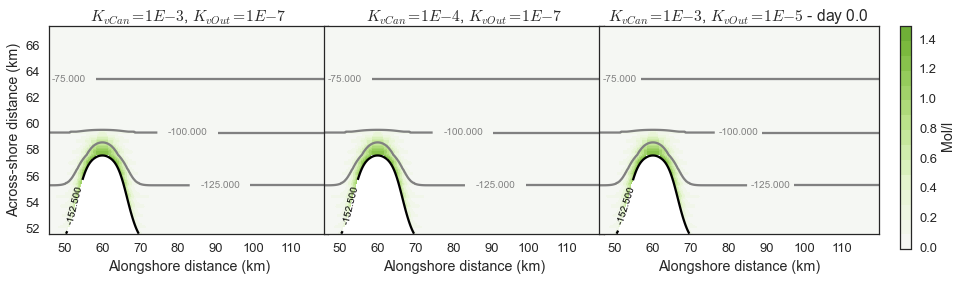

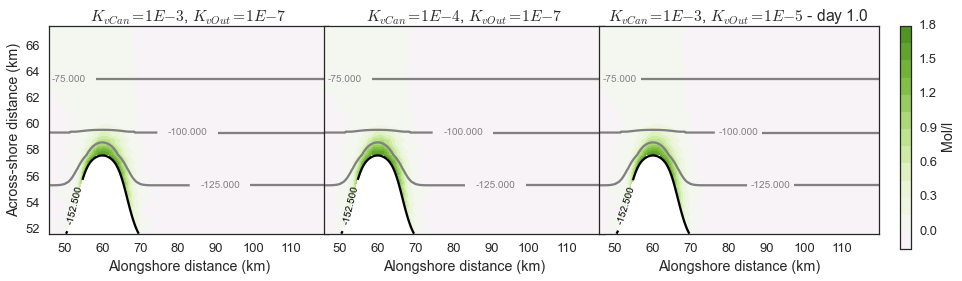

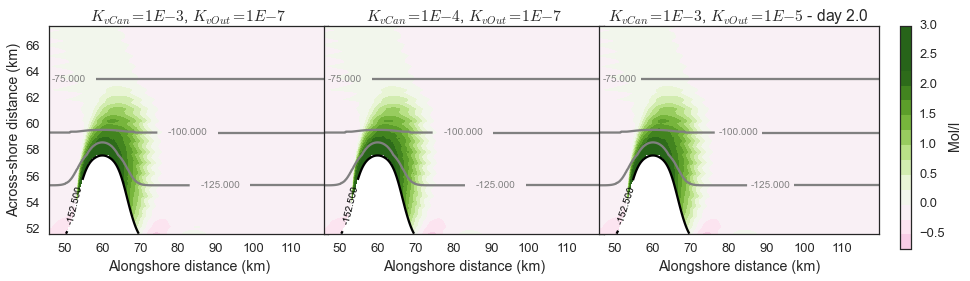

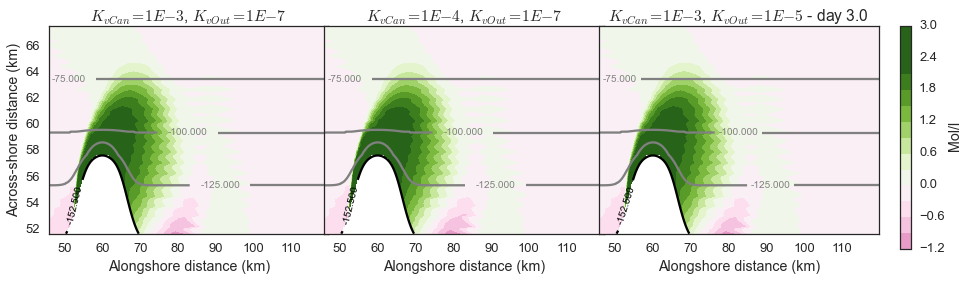

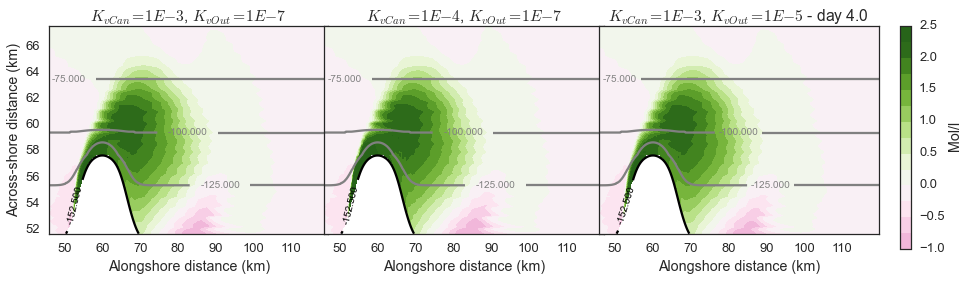

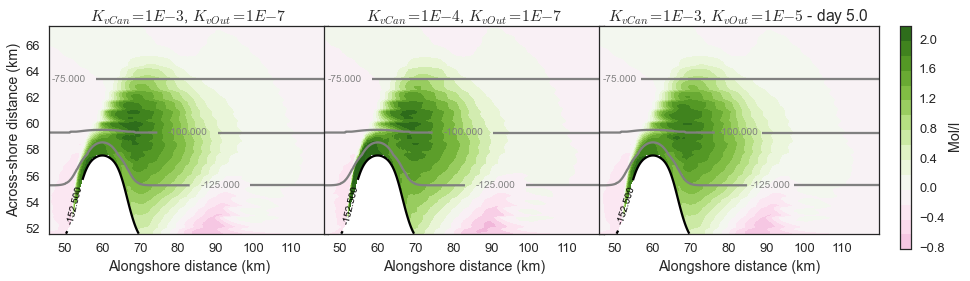

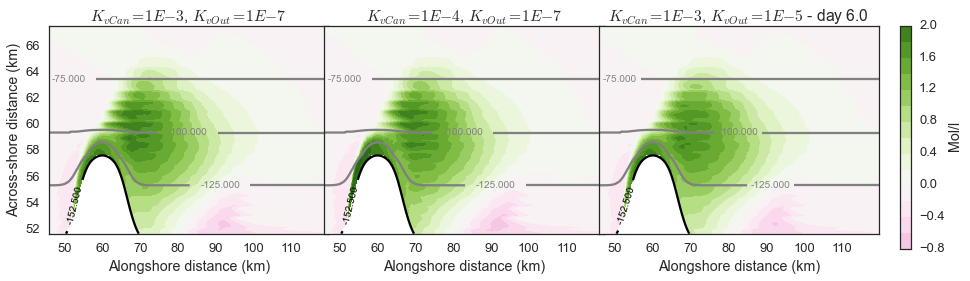

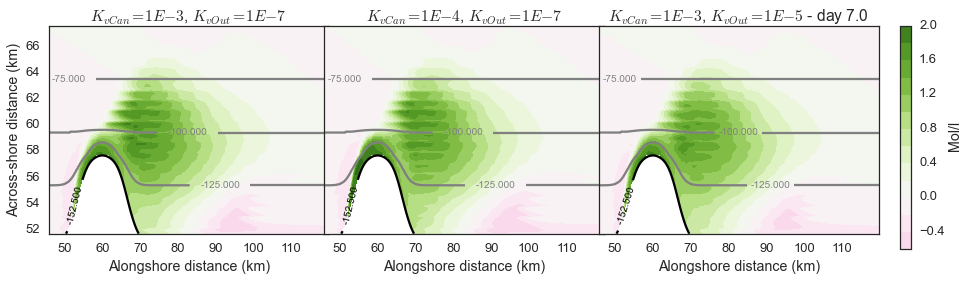

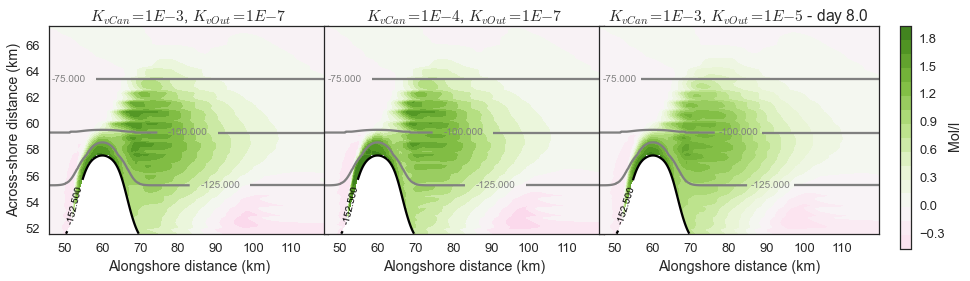

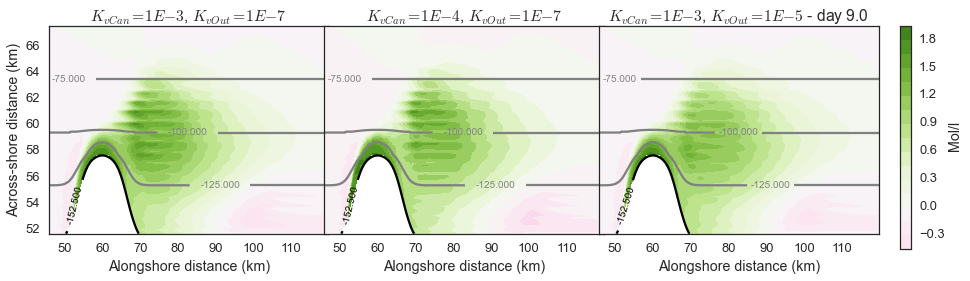

In [35]:
sns.set_context('talk', font_scale=1.0)

for tt in np.arange(0,19,2):
    
    fig,((ax1),(ax2),(ax3)) = plt.subplots(1, 3, figsize=(16, 4),  sharey=True, sharex=True)
    
    iso = ax1.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,Conc3D04[tt,227:300,100:]-Conc30[tt,227:300,100:],
                       15, vmax=2.2, vmin=-2.2,cmap='PiYG')
    cset = ax1.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,-bathy[227:300,100:],
                       [ rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],linewidth=1, rstride=2, cstride=2,zdir='z')
    ax1.clabel(cset, inline=1, fontsize=10)
    ax1.set_aspect('auto')
    ax1.set_title('$K_{vCan}=1E-3$, $K_{vOut}=1E-7$')
    ax1.set_ylabel('Across-shore distance (km)')
    ax1.set_xlabel('Alongshore distance (km)')
    
    #-------------------------------------------------------------------------------------------------------------------
    iso2 = ax2.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        Conc3D05[tt,227:300,100:]-Conc30[tt,227:300,100:],15,vmax=2.2, vmin=-2.2,cmap='PiYG')
    
    cset = ax2.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,-bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50], colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z')
    ax2.clabel(cset, inline=1, fontsize=10)
    ax2.set_aspect('auto')
    ax2.set_title('$K_{vCan}=1E-4$, $K_{vOut}=1E-7$')
    #ax2.set_ylabel('Across-shore distance (m)')
    ax2.set_xlabel('Alongshore distance (km)')
    
    #-------------------------------------------------------------------------------------------------------------------
    iso3 = ax3.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        Conc3D06[tt,227:300,100:]-Conc1noc[tt,227:300,100:],15, vmax=2.2, vmin=-2.2,cmap='PiYG')
    cax,kw = mpl.colorbar.make_axes([ax1,ax2,ax3],location='right',shrink=1, pad = -0.44)
    cb = plt.colorbar(iso3, cax=cax,**kw)
    cb.set_label('Mol/l')
    
    cset = ax3.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,-bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z')
    ax3.clabel(cset, inline=1, fontsize=10)
    ax3.set_aspect('auto')
    ax3.set_title('$K_{vCan}=1E-3$, $K_{vOut}=1E-5$ - day %0.1f ' %(tt/2.0))
    ax3.set_xlabel('Alongshore distance (km)')
    
    plt.tight_layout()
    plt.show

#fig.savefig('/ocean/kramosmu/Figures/BathyShelfBoxComplete.eps', format='eps', dpi=1000, bbox_inches='tight')